# Benchmarking

This is an adapted notebook from the POC to compare classical and quantum solutions

In [8]:
import os 
import glob
import pandas as pd 
import numpy as np
from main.tree.linkageTree import linkageCut
from main.tsp.TSP_Formulation_Methods import ( 
    create_QUBO_matrix,
    solve_qubo_with_Dwave,
    check_solution,
    check_solution_return,
    compute_general_lambdas,
    load_lambda_means,
    brute_force_finding,
    calculate_distances_cost_of_bidireccional_routes,
)
from main.vqaa.vqaa_tools import ( 
    heuristical_embedding, 
    atoms_register,
    atoms_list, 
    generate_grid,
    run_vqaa,
    plot_distribution,
)
from main.tree.utils import ( 
    view_linkage_on_map, 
    draw_centers_on_map,
    map_draw_line,
    convert_bitstring_to_matrix,
    assemble_line,
    string_to_bitstring,
)
from pipe import give_line


ModuleNotFoundError: No module named 'main'

Load inital data

In [ ]:
# Load previously stored overpy lat/lon datafile for different amenities
filepath = os.path.join('../data', 'amenities-granada.csv')
amenities_data = pd.read_csv(filepath)
    
# Create a hierarchical clustering of amenities
hierarchical_cluster = linkageCut(amenities_data)
# Set a specific number of clusters per levels. Max 9 in this POC

# Benchmarking single iterations

For our example we will impose two random nodes as start and endpoints. This works as a typical use-case: say we wanted to connect a marginalized area with another area where public services or/and green spaces are available. These extreme nodes will work as the extremes of the route. Additionally, we will fix for the route to traverse a fixed (p) number of districts (level-0 clusters).

In [3]:
np.random.seed(42)
nclusters = 4
levels = 2

N = nclusters
p = 2
startNode_0 = 3
endNode_0 = 2

labels = hierarchical_cluster.top_down_view_recur(nclusters=nclusters, levels=2)
# Fetch the distance from the centers of the first level
distances = hierarchical_cluster.dist_matrix_level(0, return_labels=False)
# Set initial global parameters

reduced_distances = distances/np.max(distances)
#lambdas = compute_general_lambdas(reduced_distances, max_N=2)
lambda_paths = glob.glob(os.path.join('data', 'lamdasOptimized', '*'))
lambdas = load_lambda_means(lambda_paths)
Q_matrix_initial,_ = create_QUBO_matrix(reduced_distances, p, startNode_0 - 1, endNode_0 - 1, lambdas)   
solution_ref = brute_force_finding(Q_matrix_initial, reduced_distances, p, False)[0][0]
print('Our solution reference is:')
print(solution_ref)

Our solution reference is:
001010000100


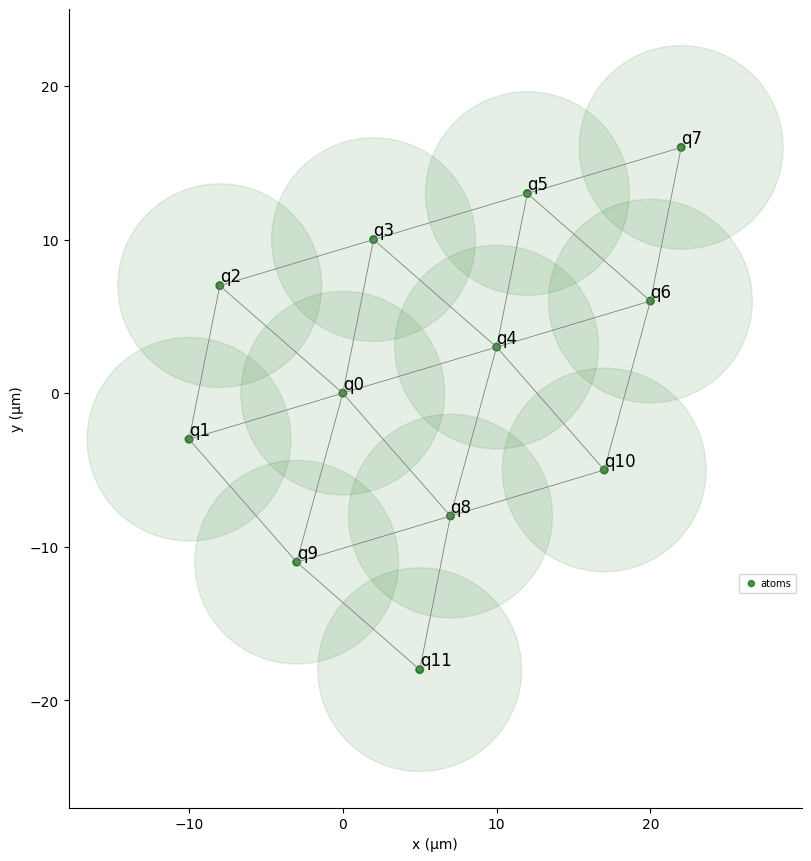

Variational in progress [3.74540119 9.50714306]
Variational in progress [4.74540119 9.50714306]
Variational in progress [ 3.74540119 10.50714306]
Variational in progress [3.02099181 8.81777302]
Variational in progress [2.33538895 8.08979726]


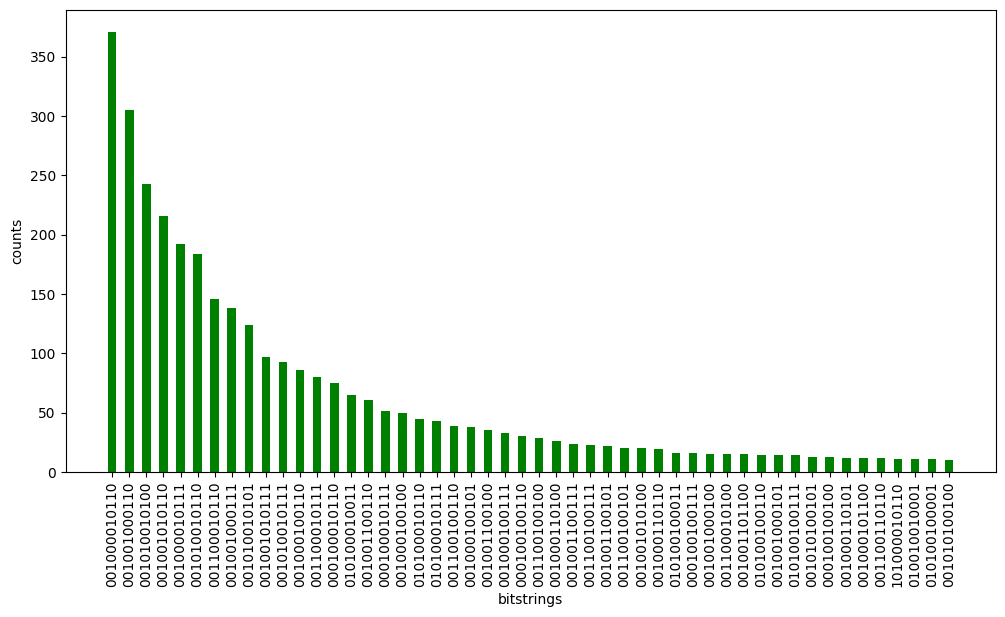

In [4]:
# Creating register and solving VQAA
coords = heuristical_embedding(atoms_list(len(Q_matrix_initial)), generate_grid(50, 50,1), Q_matrix_initial)
register = atoms_register(coords)
# Emulator options: "qutip" (pulser), "mps", and "sv"
emulator = 'sv'
C_0, x = run_vqaa(Q_matrix_initial, register, emulator)

plot_distribution(C_0, 50, "".join([str(x) for x in solution_ref]))

Same as in the POC, but we calculate the associated probabilities

In [5]:
def get_best_solution(proposed_sols, distances, s_node, e_node, p):
    # Discard solutions that do not fulfill our constraints
    constrained = [check_solution_return(string_to_bitstring(sol), N, p, s_node - 1, e_node - 1) for sol in proposed_sols]
    # Select the one(s) with lower distance associated cost
    distance_costs = np.array([calculate_distances_cost_of_bidireccional_routes(np.array(string_to_bitstring(sol)), distances, p) for sol in proposed_sols])
    print("Total distance associated to valid solutions:", distance_costs[constrained])
    print("Probability of finding it inside searched solutions:", 1/np.sum(constrained)) 
    if np.sum(constrained) == 0:
        raise ValueError('No valid solution, consider increasing the number of proposed solutions or VQAA didnt do its job')
    return proposed_sols[constrained][np.argmin(distance_costs[constrained])]

max_nchecks = 1024
number_props = min(int(len(C_0.keys())), max_nchecks) # check all register or maximum 1024
print('We are checking the constraints for these number of solutions:')
print(number_props)
print('To compare with all possible solutions:', 2**(N*(p+1)))
C_ = dict(sorted(C_0.items(), key=lambda item: item[1], reverse=True))
counts = sum(C_.values())
# To probs
for key in C_:
    C_[key] = C_[key]/counts
proposed_sols = np.array(list(C_.keys() ) )[:number_props]
level0_sols = get_best_solution(proposed_sols, distances, startNode_0, endNode_0, p) # symmetric matrix means that we are counting distances twice
print("Found solution:", level0_sols)
print("Probability associated", C_[level0_sols])

We are checking the constraints for these number of solutions:
334
To compare with all possible solutions: 4096
Total distance associated to valid solutions: [18.715  10.8896]
Probability of finding it inside searched solutions: 0.5
Found solution: 001010000100
Probability associated 0.002


Now classical solution

In [6]:
import time

t_0 = time.time()
level0_sols, _ = solve_qubo_with_Dwave(Q_matrix_initial, num_reads=1000)
t_1 = time.time()
print('Elapsed time:', t_1 - t_0)

Elapsed time: 0.1955556869506836


We run this procedure with many different configurations of N and p

In [7]:
def benchmark_classical_quantum(amenities_data, N, p, emulator, classical):
    print(f"--------- Benchmarking N = {N}, p = {p} ---------- classical={classical}")
    np.random.seed(42)
    levels = 2
    nclusters = N
    startNode_0 = 1
    endNode_0 = 2
    
    hierarchical_cluster = linkageCut(amenities_data)
    labels = hierarchical_cluster.top_down_view_recur(nclusters=N, levels=2)
    # Fetch the distance from the centers of the first level
    distances = hierarchical_cluster.dist_matrix_level(0, return_labels=False)
    reduced_distances = distances/np.max(distances)
    #lambdas = compute_general_lambdas(reduced_distances, max_N=2)
    lambda_paths = glob.glob(os.path.join('data', 'lamdasOptimized', '*'))
    lambdas = load_lambda_means(lambda_paths)
    Q_matrix_initial,_ = create_QUBO_matrix(reduced_distances, p, startNode_0 - 1, endNode_0 - 1, lambdas)
    solution_ref = brute_force_finding(Q_matrix_initial, reduced_distances, p, False)[0][0]
    if classical == False:
        # Creating register and solving VQAA
        coords = heuristical_embedding(atoms_list(len(Q_matrix_initial)), generate_grid(50, 50,1), Q_matrix_initial)
        register = atoms_register(coords, show=False)
        # Emulator options: "qutip" (pulser), "mps", and "sv"
        C, x = run_vqaa(Q_matrix_initial, register, emulator)

        counts = sum(C.values())
        # To probs
        for key in C:
            C[key] = C[key]/counts
        if solution_ref in C:
            quantum_prob = C[solution_ref]
        else:
            quantum_prob = -1
            
        return quantum_prob
    else:
        t_0 = time.time()
        level0_sols, _ = solve_qubo_with_Dwave(Q_matrix_initial, num_reads=1000)
        t_1 = time.time()
        if solution_ref == "".join([str(x) for x in level0_sols]):
            classical_time = t_1 - t_0
        else:
            classical_time = -1
        return classical_time

Computational time and probability benchmarking. This takes a while

In [22]:
max_clusters = 5
benchmarks_quant = np.zeros((max_clusters,max_clusters))
benchmarks_class = np.zeros((max_clusters,max_clusters))

for i in range(2, max_clusters):
    for j in range(1,i):
        benchmarks_quant[i,j] = benchmark_classical_quantum(amenities_data, i, j, 'qutip', False)
        benchmarks_class[i,j] = benchmark_classical_quantum(amenities_data, i, j, 'sv', True)

--------- Benchmarking N = 2, p = 1 ---------- classical=False
Variational in progress [3.74540119 9.50714306]
Variational in progress [4.74540119 9.50714306]
Variational in progress [ 3.74540119 10.50714306]
Variational in progress [2.85454095 9.05286557]
Variational in progress [3.29997107 9.28000432]
--------- Benchmarking N = 2, p = 1 ---------- classical=True
--------- Benchmarking N = 3, p = 1 ---------- classical=False
Variational in progress [3.74540119 9.50714306]
Variational in progress [4.74540119 9.50714306]
Variational in progress [ 3.74540119 10.50714306]
Variational in progress [2.99647812 8.84448611]
Variational in progress [2.29227038 8.13449212]
--------- Benchmarking N = 3, p = 1 ---------- classical=True
--------- Benchmarking N = 3, p = 2 ---------- classical=False
Variational in progress [3.74540119 9.50714306]
Variational in progress [4.74540119 9.50714306]
Variational in progress [ 3.74540119 10.50714306]
Variational in progress [3.04428508 8.79409594]
Variation

Let's showcase how the computational time increases with N and p. We use exclusively running time and the number of runs is fixed both for quantum and classical algorithm

Quantum computation time: 0.08 s
Brute force random probability: [6.25000000e-02 1.56250000e-02 1.95312500e-03 3.90625000e-03
 2.44140625e-04 1.52587891e-05]


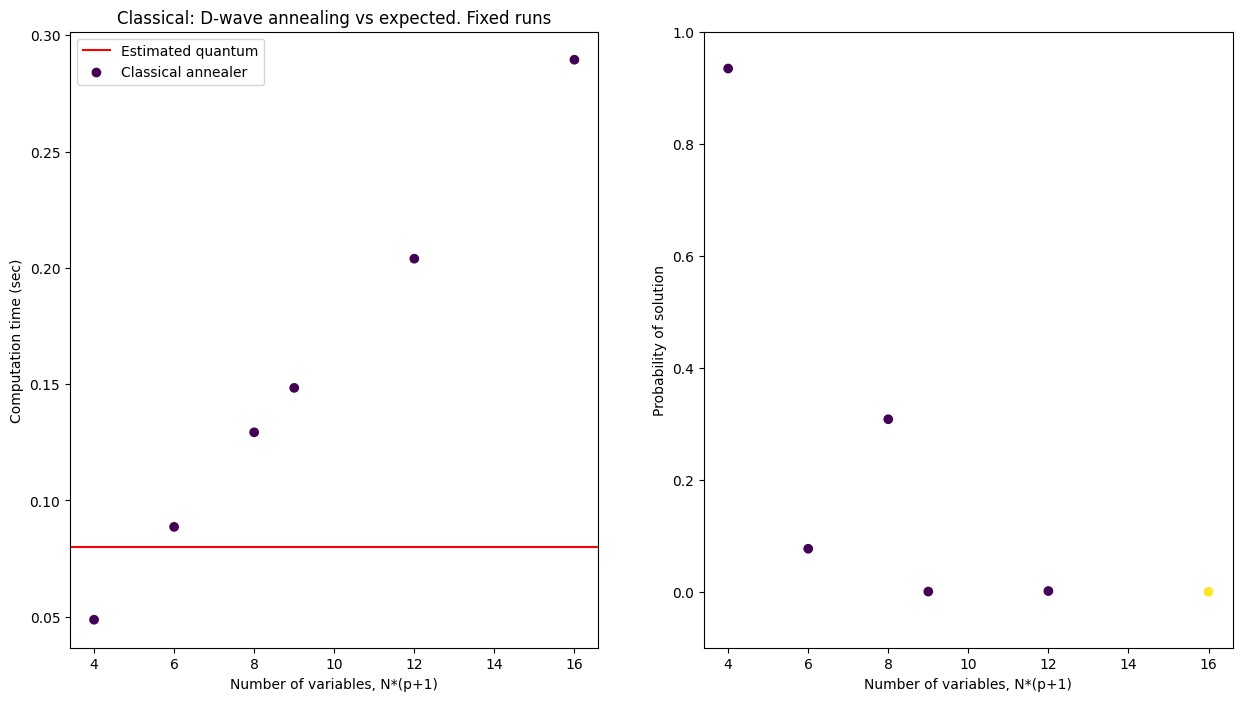

In [23]:

import matplotlib.pyplot as plt

n_bits = np.zeros((max_clusters, max_clusters))
for i in range(max_clusters):
    for j in range(max_clusters):
        n_bits[i,j] = i*(j+1)
zeros_mask = benchmarks_class.flatten() != 0

# The number of iterations in our quantum POC is 4000x5: number of runs sampled x number of iterations in the variational QAA
# Each QAA is 4000 ns. That makes a total of:
fig, ax = plt.subplots(1 ,2)
fig.set_size_inches((15,8))
quantum_time = 4000*10**(-9)*4000*5
print("Quantum computation time:", np.around(quantum_time, 3), "s")
ax[0].axhline(quantum_time, label='Estimated quantum', color='red')
failed_class = benchmarks_class.flatten()[zeros_mask] == -1
ax[0].scatter(n_bits.flatten()[zeros_mask], benchmarks_class.flatten()[zeros_mask], c=failed_class, label='Classical annealer')
ax[0].set_xlabel("Number of variables, N*(p+1)")
ax[0].set_ylabel("Computation time (sec)")
ax[0].set_title("Classical: D-wave annealing vs expected. Fixed runs")
ax[0].legend()

failed = benchmarks_quant.flatten()[zeros_mask] == -1
benchmarks_quant[benchmarks_quant == -1] = 0
rand_lim = 1/2**(n_bits.flatten()[zeros_mask])
print('Brute force random probability:', rand_lim)
ax[1].scatter(n_bits.flatten()[zeros_mask], benchmarks_quant.flatten()[zeros_mask], c = failed)
ax[1].set_ylim([-0.1,1])
ax[1].set_xlabel('Number of variables, N*(p+1)')
ax[1].set_ylabel('Probability of solution')
plt.show()

If some points appear as yellow, it means that the optimal solution was not found. This applies for both plots. For the right plot, that means that it did not appear in the 4000 samples. In all instances, D-wave annealer finds the solution with only 1000 reads. This means that there is clear room for improving the quantum approach, or in the simulation, but the solutions can be consistently found if done right.

Now we compare the probability to obtain the solution against brute force probabilities

Brute force random probability: [6.25000000e-02 1.56250000e-02 1.95312500e-03 3.90625000e-03
 2.44140625e-04 1.52587891e-05]


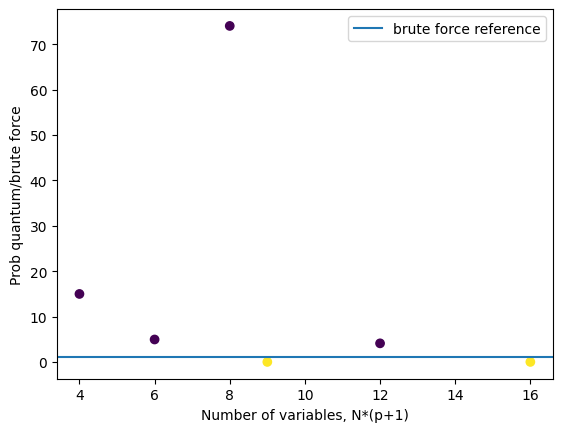

In [21]:
plt.close()
benchmarks_quant[benchmarks_quant == -1] = 0
rand_lim = 1/2**(n_bits.flatten()[zeros_mask])
print('Brute force random probability:', rand_lim)
plt.scatter(n_bits.flatten()[zeros_mask], benchmarks_quant.flatten()[zeros_mask]/rand_lim, c = failed)
plt.axhline(1, label='brute force reference')
plt.xlabel('Number of variables, N*(p+1)')
plt.ylabel('Prob quantum/brute force')
plt.legend()
plt.show()

In [25]:
np.mean(benchmarks_class.flatten()[zeros_mask])

0.15143040815989176

We take as estiamtes for quantum computation 0.08 s and for classical computation a mean of 0.15 s, but with clear margin for improvement in larger problems.